In [85]:
from skimage.io import imread, imshow
from skimage.transform import resize, rescale 
import numpy as np
import matplotlib
import gc
import matplotlib.cm as cm
from math import sqrt

/home/pavel/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


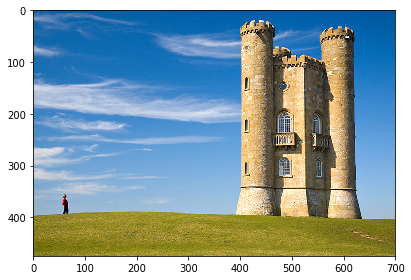

In [125]:
imgPath = '/home/pavel/MyDocs/ComputerVision/Task2/publicTests/01_input/img.png'
maskPath = '/home/pavel/MyDocs/ComputerVision/Task2/publicTests/01_input/mask.png'
img = imread(imgPath, plugin ='matplotlib')
maskImg = imread(maskPath, plugin ='matplotlib')
imshow(img)

/home/pavel/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


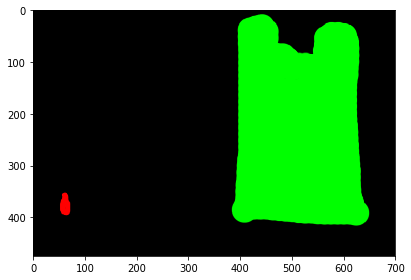

In [126]:
imshow(maskImg)

In [127]:
print(img[0, 0, 0])
print(img[0, 0, 1])
print(img[0, 0, 2])

0.019607844
0.36862746
0.61960787


In [128]:
def convert_img_to_mask(img):
    return ((img[:, :, 0] != 0) * -1 + (img[:, :, 1] != 0)).astype('int8')
mask = convert_img_to_mask(maskImg)

In [129]:

def seam_carve(img, mode, mask=None):
    if mask is None:
        mask = np.zeros([img.shape[0], img.shape[1]])

    if mode == 'vertical shrink' or mode == 'horizontal shrink':
        if mode == 'vertical shrink':
            img = np.rot90(img, 1)
            mask = np.rot90(mask, 1)

        seamM = seam_mask(img, mask)
        img, mask = delete_seam(img, mask)

        if mode == 'vertical shrink':
            for i in range(3):
                img = np.rot90(img, 1)
                mask = np.rot90(mask, 1)
                seamM = np.rot90(seamM, 1)
    else:
        if mode == 'vertical expand':
            img = np.rot90(img, 1)
            mask = np.rot90(mask, 1)

        seamM = seam_mask(img, mask)
        img, mask = add_seam(img, mask)

        if mode == 'vertical expand':
            for i in range(3):
                img = np.rot90(img, 1)
                mask = np.rot90(mask, 1)
                seamM = np.rot90(seamM, 1)

    return img, mask
'''
, seamM
'''

def energy_matrix(img, mask):
    xSize = img.shape[0]
    ySize = img.shape[1]
    bright = np.zeros([xSize, ySize], dtype=np.float)
    bright = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

    derX = np.zeros([xSize, ySize], dtype=np.float)
    derY = np.zeros([xSize, ySize], dtype=np.float)

    derX[0, :] = bright[1, :] - bright[0, :]
    derX[xSize - 1, :] = bright[xSize - 1, :] - bright[xSize - 2, :]
    derX[1:xSize - 1, :] = bright[2:, :] - bright[:xSize - 2, :]

    derY[:, 0] = bright[:, 1] - bright[:, 0]
    derY[:, ySize - 1] = bright[:, ySize - 1] - bright[:, ySize - 2]
    derY[:, 1:ySize - 1] = bright[:, 2:] - bright[:, :ySize - 2]
    
    bright = None
    gc.collect()
    
    energy = np.zeros([xSize, ySize], dtype=np.float)
    energy = np.sqrt(derX**2 + derY**2)
    
    derX = None
    derY = None
    gc.collect()
    
    myConst = img.shape[0] * img.shape[1] * 256
    energy += mask * myConst
    return energy


def cumulative_matrix(img, mask):
    energy = energy_matrix(img, mask)
    cumulative = np.zeros([energy.shape[0], energy.shape[1]], dtype=np.float)

    cumulative[0, :] = energy[0, :].copy()
    for x in range(1, energy.shape[0]):
        for y in range(0, energy.shape[1]):
            if y == 0:
                cumulative[x][y] = energy[x][y] + min(cumulative[x - 1][y], cumulative[x - 1][y + 1])
            elif y == energy.shape[1] - 1:
                cumulative[x][y] = energy[x][y] + min(cumulative[x - 1][y], cumulative[x - 1][y - 1])
            else:
                cumulative[x][y] = energy[x][y] + min(cumulative[x - 1][y - 1], cumulative[x - 1][y],
                                                      cumulative[x - 1][y + 1])
    energy = None
    gc.collect()
    return cumulative


def find_seam(img, mask):
    cum_matrix = cumulative_matrix(img, mask)
    xSize, ySize = cum_matrix.shape

    seam = np.zeros(xSize, dtype=np.uint)
    seam[-1] = np.argmin(cum_matrix[-1, :])

    for x in range(xSize - 2, -1, -1):
        prev_y = seam[x + 1]
        if prev_y == 0:
            seam[x] = np.argmin(cum_matrix[x, : 2])
        else:
            seam[x] = prev_y - 1 + np.argmin(cum_matrix[x, int(prev_y - 1): int(min(prev_y + 2, ySize))])
    cum_matrix = None
    gc.collect()
    return seam


def seam_mask(img, mask):
    xSize, ySize = img.shape[:2]
    seamMatrix = np.zeros([xSize, ySize], dtype=int)
    seam = find_seam(img, mask)
    for x in range(xSize):
        seamMatrix[x][seam[x]] = 1
    seam = None
    gc.collect()
    return seamMatrix


def show_seam(img, mask, mode):
    xSize, ySize = img.shape[:2]
    seam = find_seam(img, mask)
    imgCopy = img.copy()

    if mode == 'horizontal shrink':
        for x in range(xSize):
            imgCopy[x, seam[x], 0] = 1
            imgCopy[x, seam[x], 1] = 0
            imgCopy[x, seam[x], 2] = 0
    elif mode == 'vertical shrink':
        print(seam)
        for y in range(ySize):
            imgCopy[seam[y], y, 0] = 1
            imgCopy[seam[y], y, 1] = 0
            imgCopy[seam[y], y, 2] = 0

    imshow(imgCopy)


def delete_seam(img, mask):
    seam = find_seam(img, mask)
    xSize, ySize = img.shape[:2]
    newImg = np.zeros([xSize, ySize - 1, 3], dtype=np.float)
    newMask = np.zeros([xSize, ySize - 1])

    for x in range(xSize - 1, -1, -1):
        curY = seam[x]
        newImg[x, :, 0] = np.delete(img[x, :, 0], curY)
        newImg[x, :, 1] = np.delete(img[x, :, 1], curY)
        newImg[x, :, 2] = np.delete(img[x, :, 2], curY)
        newMask[x, :] = np.delete(mask[x, :], curY)

    seam = None
    gc.collect()
    return newImg, newMask


def expand_mask(img, mask):
    seam = find_seam(img, mask)
    xSize, ySize = img.shape[:2]

    newMask = np.zeros([xSize, ySize + 1])
    newMask[:, :ySize] = mask
    for x in range(xSize):
        newMask[x, seam[x]] = 1
    seam = None
    gc.collect()
    return newMask


def add_seam(img, mask):
    seam = find_seam(img, mask)
    xSize, ySize = img.shape[:2]

    newImg = np.zeros([xSize, ySize + 1, 3], dtype=np.float)
    for x in range(xSize):
        y = seam[x]
        for color in range(3):
            newImg[int(x), :int(y + 1), color] = img[int(x), :int(y + 1), color]
            newImg[int(x), int(y + 2):, color] = img[int(x), int(y + 1):, color]
            newImg[int(x), int(y + 1), color] = np.average(img[int(x), int(y): int(y + 2), color])
    seam = None
    gc.collect()
    newMask = expand_mask(img, mask)
    return newImg, newMask

In [130]:

def seam_carve1(img, mode, mask=None):
    if mask is None:
        mask = np.zeros([img.shape[0], img.shape[1]])
    
    if mode[0] == 'v':
        img = np.rot90(img, 1)
        mask = np.rot90(mask, 1)
        
    '''
    Calculating energy Matrix
    '''
    xSize = img.shape[0]
    ySize = img.shape[1]
    bright = np.zeros([xSize, ySize], dtype=np.float)
    bright = 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2]

    derX = np.zeros([xSize, ySize], dtype=np.float)
    derY = np.zeros([xSize, ySize], dtype=np.float)

    derX[0, :] = bright[1, :] - bright[0, :]
    derX[xSize - 1, :] = bright[xSize - 1, :] - bright[xSize - 2, :]
    derX[1:xSize - 1, :] = bright[2:, :] - bright[:xSize - 2, :]

    derY[:, 0] = bright[:, 1] - bright[:, 0]
    derY[:, ySize - 1] = bright[:, ySize - 1] - bright[:, ySize - 2]
    derY[:, 1:ySize - 1] = bright[:, 2:] - bright[:, :ySize - 2]
    
    bright = None
    gc.collect()
    
    energy = np.zeros([xSize, ySize], dtype=np.float)
    energy = np.sqrt(derX**2 + derY**2)
    
    derX = None
    derY = None
    gc.collect()
    
    myConst = img.shape[0] * img.shape[1] * 256
    energy += mask * myConst
    
    '''
    Calculating cumulative Matrix
    '''
    
    cumulative = np.zeros([energy.shape[0], energy.shape[1]], dtype=np.float)

    cumulative[0, :] = energy[0, :].copy()
    for x in range(1, energy.shape[0]):
        for y in range(0, energy.shape[1]):
            if y == 0:
                cumulative[x][y] = energy[x][y] + min(cumulative[x - 1][y], cumulative[x - 1][y + 1])
            elif y == energy.shape[1] - 1:
                cumulative[x][y] = energy[x][y] + min(cumulative[x - 1][y], cumulative[x - 1][y - 1])
            else:
                cumulative[x][y] = energy[x][y] + min(cumulative[x - 1][y - 1], cumulative[x - 1][y],
                                                      cumulative[x - 1][y + 1])
    energy = None
    gc.collect()

    '''
    Finding seam
    '''
    seam = np.zeros(xSize, dtype=np.uint)
    seam[-1] = np.argmin(cumulative[-1, :])

    for x in range(xSize - 2, -1, -1):
        prev_y = seam[x + 1]
        if prev_y == 0:
            seam[x] = np.argmin(cumulative[x, : 2])
        else:
            seam[x] = prev_y - 1 + np.argmin(cumulative[x, int(prev_y - 1): int(min(prev_y + 2, ySize))])
    cumulative = None
    gc.collect()
    
    
    '''
    Seam Mask
    '''
    xSize, ySize = img.shape[:2]
    seamM = np.zeros([xSize, ySize], dtype=int)
    for x in range(xSize):
        seamM[x][seam[x]] = 1

    '''
    Picture alternation
    '''
    
    
    if mode[-1] == 'k':
        xSize, ySize = img.shape[:2]
        newImg = np.zeros([xSize, ySize - 1, 3], dtype=np.float)
        newMask = np.zeros([xSize, ySize - 1])

        for x in range(xSize - 1, -1, -1):
            curY = seam[x]
            newImg[x, :, 0] = np.delete(img[x, :, 0], curY)
            newImg[x, :, 1] = np.delete(img[x, :, 1], curY)
            newImg[x, :, 2] = np.delete(img[x, :, 2], curY)
            newMask[x, :] = np.delete(mask[x, :], curY)
        
        img = newImg.copy()
        mask = newMask.copy()
        newImage = None
        newMask = None
        seam = None
        gc.collect()
        
    else:
        xSize, ySize = img.shape[:2]

        newImg = np.zeros([xSize, ySize + 1, 3], dtype=np.float)
        for x in range(xSize):
            y = seam[x]
            for color in range(3):
                newImg[int(x), :int(y + 1), color] = img[int(x), :int(y + 1), color]
                newImg[int(x), int(y + 2):, color] = img[int(x), int(y + 1):, color]
                newImg[int(x), int(y + 1), color] = np.average(img[int(x), int(y): int(y + 2), color])
        xSize, ySize = img.shape[:2]

        newMask = np.zeros([xSize, ySize + 1])
        newMask[:, :ySize] = mask
        for x in range(xSize):
            newMask[x, seam[x]] = 1
        img = newImg.copy()
        mask = newMask.copy()
        newImage = None
        newMask = None
        seam = None
        gc.collect()
    
    '''
    Result
    '''
    if mode[0] == 'v':
        for i in range(3):
            img = np.rot90(img, 1)
            mask = np.rot90(mask, 1)
            seamM = np.rot90(seamM, 1)

        
    return img, mask, seamM

In [131]:
mode = 'horizontal shrink'
sz = 10

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


/home/pavel/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


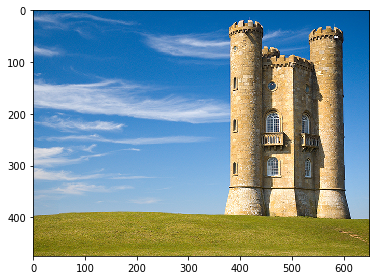

In [132]:
img1 = img
mask1 = mask
for k in range(50):
    print(k)
    img1, mask1, x = seam_carve1(img1, mode, mask1)
imshow(img1)


/home/pavel/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


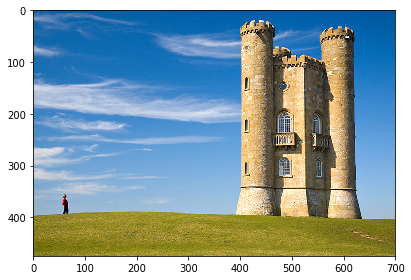

In [133]:
imshow(img)